In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, f1_score, precision_recall_curve, roc_auc_score, roc_curve

from utils import create_feature_matrix, create_target_vector, create_train_test_matrices

### Import Epigenetics and RNA-seq data

In [3]:
master_folder_path = 'Multiome'

dfs_epigenetics = {}
dfs_transcriptomics = {}

# Iterate through all subdirectories and files in the master folder
for root, dirs, files in os.walk(master_folder_path):
    # If we are at the third level of directories get the histone modification assay data
    if len(root.split("/")) == 3:
        cell_line = root.split("/")[1]
        if cell_line not in dfs_epigenetics:
            dfs_epigenetics[cell_line] = []
        for file in files:
            if file.endswith('.csv'):
                # Construct the full path to the CSV file
                csv_file_path = os.path.join(root, file)
                histone_mark = csv_file_path.split("_")[-1].strip(".csv")
        
                # Read the CSV file using pandas
                df = pd.read_csv(csv_file_path)
                df['annotation'] = df['annotation'].apply(lambda x: x.split(" (")[0])
                df['annotation'] = df['annotation'] + f"_{histone_mark}"
                dfs_epigenetics[cell_line].append(df)
    # If we are at the second level of directories get RNA seq data
    if len(root.split("/")) == 2:
        cell_line = root.split("/")[1]
        for file in files:
            if file.endswith('.tsv'):
                tsv_file_path = os.path.join(root, file)
                rna_seq = pd.read_csv(tsv_file_path, sep = '\t')
                dfs_transcriptomics[cell_line] = rna_seq

### Define feautures and target vectors

In [4]:
# Just using this as an example, can be changed or you can loop through the keys in df_epigenetics
tissue = 'Mammary Epithelial Cell'

In [5]:
X_train, X_test, y_train, y_test = create_train_test_matrices(dfs_epigenetics[tissue],dfs_transcriptomics[tissue])

/Users/erykkropiwnicki/Personal_Projects/biohack-nyc/utils.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncbi_gene_id_map['NCBI gene (formerly Entrezgene) ID'] = ncbi_gene_id_map['NCBI gene (formerly Entrezgene) ID'].astype(int).astype(str)


### Regression Models

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'XGBoost': XGBRegressor(),
    'LogisticRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor()
}

In [7]:
output_dict = {}
# define model
for model_name, model in models.items():
    # fit model
    model.fit(X_train, y_train)
    # predict on heldout set
    yhat = model.predict(X_test)
    # save MAE
    mae = mean_absolute_error(y_test,yhat)
    # reattach gene names to y_preds
    y_preds = pd.Series(yhat)
    y_preds.index = y_test.index
    # scatter data output
    scatter_data = pd.concat([y_test,y_preds], axis = 1).rename({'TPM':'y_true',0:'y_pred'},axis=1)
    # compute pearson correlation coefficient
    corr_coef = np.corrcoef(y_test.tolist(), y_preds.tolist())[0][1]
    output_dict[model_name] = [mae,corr_coef]
output_df = pd.DataFrame(output_dict, index = ['mean_average_error','pearson_correlation'])


In [8]:
output_df

,XGBoost,LogisticRegression,RandomForest
mean_average_error,0.73582,1.136312,0.740230
pearson_correlation,0.82878,0.689147,0.817028


### Classification models

In [9]:
X_train, X_test, y_train, y_test = create_train_test_matrices(dfs_epigenetics[tissue],dfs_transcriptomics[tissue],vector_type="binary")

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'XGBoost': XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
}

In [11]:
def plot_roc_auc(output_df):
    for i in range(len(output_df)):
        plt.plot(output_df['fpr'][i], output_df['tpr'][i], label=f"{output_df.index[i]} (AUC = {round(output_df['roc_auc'][i],4)})") 

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.show()
    return plt

def plot_pr_curve(output_df):
    for i in range(len(output_df)):
        plt.plot(output_df['recall'][i], output_df['precision'][i], label=f"{output_df.index[i]} (F1 score = {round(output_df['f1_score'][i],4)})")

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal for random classifier
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall (PRC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    return plt

/Users/erykkropiwnicki/.pyenv/versions/3.9.9/envs/biohack/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/p4/gdh28gk568sbf143d4p59vdw0000gq/T/ipykernel_70476/1357911501.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(output_df['fpr'][i], output_df['tpr'][i], label=f"{output_df.index[i]} (AUC = {round(output_df['roc_auc'][i],4)})")  #

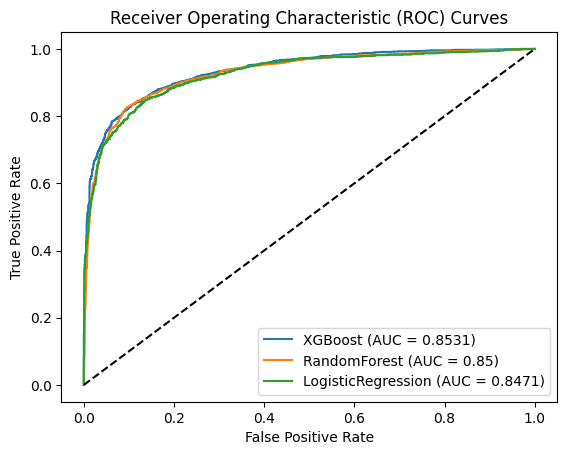

/var/folders/p4/gdh28gk568sbf143d4p59vdw0000gq/T/ipykernel_70476/1357911501.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(output_df['recall'][i], output_df['precision'][i], label=f"{output_df.index[i]} (F1 score = {round(output_df['f1_score'][i],4)})")  # Simplified AUC calculation for illustration


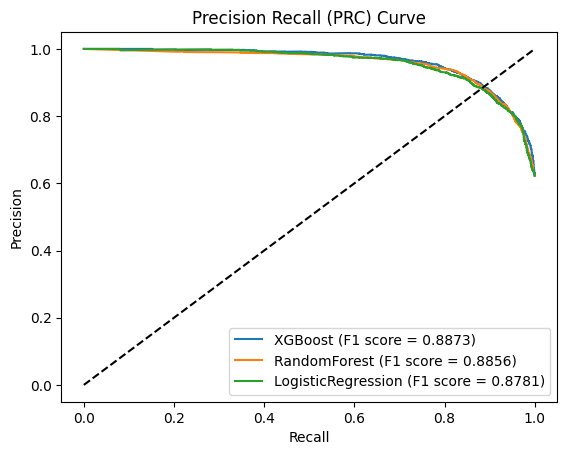

<module 'matplotlib.pyplot' from '/Users/erykkropiwnicki/.pyenv/versions/3.9.9/envs/biohack/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [12]:
output_dict = {}
# define model
for model_name, model in models.items():
    # fit model
    model.fit(X_train, y_train)
    # predict on heldout set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # compute roc auc
    roc_auc = roc_auc_score(y_test,y_pred)
    # compute f1 score (precision-recall)
    f1 = f1_score(y_test,y_pred)
    output_dict[model_name] = [roc_auc,f1]
    # get fpr and tpr for plotting roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # get precision and recall for PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    output_dict[model_name] = [roc_auc,fpr,tpr,f1,precision,recall]
output_df = pd.DataFrame(output_dict, index = ['roc_auc','fpr','tpr','f1_score','precision','recall']).T
plot_roc_auc(output_df)
plot_pr_curve(output_df)


### Generalizability

Fit the model on the Human Mammary Epithelial dataset

In [13]:
model = XGBClassifier().fit(X_train, y_train)
# predict on heldout set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test,y_pred)

Let's see how the model performs on the other datasets when trained on Human Mammary Epithelial dataset

In [14]:
dfs_epigenetics.keys()

dict_keys(['Mammary Epithelial Cell', 'GM12878', 'HepG2', 'H9', 'Myotube', 'K562'])

In [17]:
for label in dfs_epigenetics.keys():
    X_train_heldout, X_test_heldout, y_train_heldout, y_test_heldout = create_train_test_matrices(dfs_epigenetics[label],
                                                                                                dfs_transcriptomics[label],
                                                                                                vector_type="binary")
    y_pred = model.predict(X_train_heldout)
    y_pred_prob = model.predict_proba(X_train_heldout)[:, 1]

    print(f"{label}:{roc_auc_score(y_train_heldout,y_pred)}")

Mammary Epithelial Cell:0.9012341724726861
GM12878:0.8409173876887278
HepG2:0.8686342395001755
H9:0.8323005292253357
Myotube:0.8406231287722532
K562:0.8519960172433185


The model trained on `Human Mammary Epithelial` dataset appears to predict whether a gene is expressed or not relatively well in other datasets